In [10]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%matplotlib inline
import math,sys,os,numpy as np
from numpy.random import random

from module import utils;reload(utils)
from utils import *

from matplotlib import pyplot as plt, rcParams, animation, rc
from __future__ import print_function, division
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
rc('animation', html='html5')
rcParams['figure.figsize'] = 3, 3
%precision 4
np.set_printoptions(precision=4, linewidth=100)

In [11]:
def linearModel(input_shape,learning_rate):
    lm = Sequential([ Dense(1, input_shape=input_shape) ])
    lm.compile(optimizer=SGD(lr=learning_rate), loss='mse')
    return lm
def linear(a,b,x): return a*x + b


# 1. Planning


1. 合并所有知识点为一个 data set 
2. 清理 lessonprogress ，将 L1MC01.L1MC012.score 打平
3. lessonprogress join knowledge 以及 baby age
4. 按 sublessonID, sectionID, baby age， knowledge type 统计
5. 按年龄段画出各年龄段平均分数的雷达图

# 2. Preparing the Data


## 2.0 Connecting DB

In [ ]:
import pandas as pd
from pymongo import MongoClient

def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        print(mongo_uri)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]

def dev_db():
    db = _connect_mongo(host="dev.jiliguala.com", port=27646, username="JLBackEnd", password="a74528a4-d8f0-478f-8431-3ad318afd4b2", db="JLGL")
    return db

def toDF(cursor): 
    return pd.DataFrame(list(cursor))

def query(db,collection, query={}, no_id=False):
    """ Read from Mongo and Store into DataFrame """

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

In [ ]:
"""
db = dev_db()
cursor = db["lessonprogress"].aggregate([
    {"$match": {"_id":"026c821b48084959b265aa734c3f024c"}},
#     {"$project" : {"_id":1,"MC.L2MC.status": 1}},
    {"$project" : {"_id":1,"MC.L2MC.status": 1, "type": { "$concat" : ["L2MC",""]}}},# how to get $index?
  #  {"$unwind" : { "path" : "$MC.L2MC.status",  "includeArrayIndex": "arrayIndex"}}, #需要 3.2 版本才支持
    {"$unwind" : "$MC.L2MC.status"},
#         {"$unwind" : "$MC.L2MC.status"},
#     { "$group" : {"_id":"$_id","sec": { "$push" : "$$CURRENT._id"}}}
#     { "$group" : {"_id":"$_id","MC": "$$CURRENT._id"}}
])
result = toDF(cursor)
result.head()
"""

db = dev_db()

## 2.1 Knowledge



In [17]:
knowledge = pd.read_csv('data/JLGL.knowledge.csv')

In [18]:
knowledge.sample(3)

_id     cat      text  typ
1178  L2MC3721  listen     beach   10
624   L1PH1046   write         M  110
2504  L3PH1445   write  this, he  125

In [223]:
catIDsMap=dict(list(knowledge.groupby('cat')['_id']))
print(catIDsMap.keys())

['read', 'write', 'speak', 'listen']


##  2.2 Lesson Progress

### 2.2.1 Flatten lessonprogress

mapReduce lessonprogress collection to extract sublesson and section scores, save to baby_stats collection


```
// *** 3T Software Labs, Studio 3T: MapReduce Job ****

// Variable for map
var __3tsoftwarelabs_map = function map() {
    function pad(n, width, z) {
        z = z || '0';
        n = n + '';
        return n.length >= width ? n : new Array(width - n.length + 1).join(z) + n;
    }

    var result = {}
    var hasGrade = false

    var levels = ["L1", "L2", "L3"]
    var types = ["MC", "PH"]
    var sublessons = {}
    var sections = {}
    var self = this

    types.forEach(function (type) {
        var mc = self[type]
        if (mc) {
            levels.forEach(function (level) {
                var key = level + type
                var L1MC = mc[key]
                if (L1MC && L1MC.status.length > 0) {
                    var lessons = L1MC.status
                    for (var i = 0; i < lessons.length; i++) {
                        var lessonID = key + pad(i + 1, 2) //L1MC01
                        var lesson = lessons[i]
                        for (var j = 1; j < lesson.length; j++) {
                            var subLessonGrade = lesson[j]
                            if (subLessonGrade > 0) {
                                var subLessonID = lessonID + (j + 1) //L1MC012
                                sublessons[subLessonID] = subLessonGrade
                                hasGrade = true
                            }
                        }
                    }
                }
            })
        }
    })

    for (var sublessonID in sublessons) {
      var lessonID = sublessonID.substr(0,6)
      var lesson = this[lessonID]
	 if(lesson){
	   var sublesson = lesson[sublessonID]
	   if (sublesson) {
	     for (var i = 1; i< 10; i++){
	       var sectionID = sublessonID+i
	       if (sublesson[sectionID]){
	         sections[sectionID]=sublesson[sectionID].score
	       }
	     }
	   }
	 }
    }
    
    result["bid"] = this._id
    result["sublessons"] = sublessons
    result["sections"] = sections
    if (hasGrade) emit(this._id, result)
};

// Variable for reduce
var __3tsoftwarelabs_reduce = function (key, values) {

    var reducedValue = "" + values;
    return reducedValue;
};

db.runCommand({ 
    mapReduce: "lessonprogress",
    map: __3tsoftwarelabs_map,
    reduce: __3tsoftwarelabs_reduce,
    out: { "replace" : "baby_stats"},
    sort: {  },
    inputDB: "Luosky",
 });

```


### 2.2.2 Join bd from babies collection

```
db.baby_stats.aggregate(

	// Pipeline
	[
		// Stage 1
		{
			$lookup: {
			    "from" : "babies",
			    "localField" : "value.bid",
			    "foreignField" : "_id",
			    "as" : "baby"
			}
		},

		// Stage 2
		{
			$unwind: {
			    path : "$baby"
			}
		},

		// Stage 3
		{
			$replaceRoot: {
			    newRoot: {
			      _id : "$_id",
			      sections : "$value.sections",
			      sublessons: "$value.sublessons",
			      bd: "$baby.bd"
			    }
			}
		},

		// Stage 4
		{
			$out: "baby_stats"
		},

	]

	// Created with Studio 3T, the IDE for MongoDB - https://studio3t.com/

);

```

### 2.2.3 Exporting CSV

将 baby_stats collection 导出成 baby_stats.csv

### 2.2.4 Importing from CSV and process

In [213]:
lessonProgress = pd.read_csv('data/JLGL.baby_stats.csv',parse_dates = True,index_col=[0])
lessonProgress.index.names = ['bid']
lessonProgress.sample()

sections.L1MC0121  sections.L1MC0122  \
bid                                                                      
101fb083e0084cde9955392785dbf42e              100.0              100.0   

                                  sections.L1MC0123  sections.L1MC0124  \
bid                                                                      
101fb083e0084cde9955392785dbf42e              100.0              100.0   

                                  sections.L1MC0125  sections.L1MC0126  \
bid                                                                      
101fb083e0084cde9955392785dbf42e              100.0              100.0   

                                  sections.L1PH0121  sections.L1PH0122  \
bid                                                                      
101fb083e0084cde9955392785dbf42e              100.0              100.0   

                                  sections.L1PH0123  sections.L1PH0124  \
bid                                                                      
101fb083e0084cde9955392785dbf42e              100.0              100.0   

                                            ...             \
bid                                         ...              
101fb083e0084cde9955392785dbf42e            ...              

                                  sublessons.L3MC122  sublessons.L3MC132  \
bid                                                                        
101fb083e0084cde9955392785dbf42e                 NaN                 NaN   

                                  sublessons.L3MC212  sublessons.L1PH093  \
bid                                                                        
101fb083e0084cde9955392785dbf42e                 NaN                 NaN   

                                  sublessons.L1PH094  sublessons.L2PH023  \
bid                                                                        
101fb083e0084cde9955392785dbf42e                 NaN                 NaN   

                                  sublessons.L2PH083  sublessons.L3MC043  \
bid                                                                        
101fb083e0084cde9955392785dbf42e                 NaN                 NaN   

                                  sublessons.L3MC153                        bd  
bid                                                                             
101fb083e0084cde9955392785dbf42e                 NaN  2017-07-13T00:00:00.000Z  

[1 rows x 2139 columns]

In [136]:
lessonProgress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Columns: 347 entries, value.bid to value.sublessons.L3MC023
dtypes: float64(346), object(1)
memory usage: 569.4+ KB


In [214]:
# Move bid & bd to the front of the table
bd = lessonProgress['bd']
lessonProgress.drop(labels=['bd'], axis=1,inplace = True)
lessonProgress.insert(0, 'bd', bd)
lessonProgress.sample()

bd  sections.L1MC0121  \
bid                                                                             
ef25956e80cc4ed8b7e28c1c90408e81  2015-09-14T00:00:00.000Z              100.0   

                                  sections.L1MC0122  sections.L1MC0123  \
bid                                                                      
ef25956e80cc4ed8b7e28c1c90408e81               50.0              100.0   

                                  sections.L1MC0124  sections.L1MC0125  \
bid                                                                      
ef25956e80cc4ed8b7e28c1c90408e81              100.0              100.0   

                                  sections.L1MC0126  sections.L1PH0121  \
bid                                                                      
ef25956e80cc4ed8b7e28c1c90408e81               50.0                NaN   

                                  sections.L1PH0122  sections.L1PH0123  \
bid                                                                      
ef25956e80cc4ed8b7e28c1c90408e81                NaN                NaN   

                                         ...          sublessons.L3MC082  \
bid                                      ...                               
ef25956e80cc4ed8b7e28c1c90408e81         ...                         NaN   

                                  sublessons.L3MC122  sublessons.L3MC132  \
bid                                                                        
ef25956e80cc4ed8b7e28c1c90408e81                 NaN                 NaN   

                                  sublessons.L3MC212  sublessons.L1PH093  \
bid                                                                        
ef25956e80cc4ed8b7e28c1c90408e81                 NaN                 NaN   

                                  sublessons.L1PH094  sublessons.L2PH023  \
bid                                                                        
ef25956e80cc4ed8b7e28c1c90408e81                 NaN                 NaN   

                                  sublessons.L2PH083  sublessons.L3MC043  \
bid                                                                        
ef25956e80cc4ed8b7e28c1c90408e81                 NaN                 NaN   

                                  sublessons.L3MC153  
bid                                                   
ef25956e80cc4ed8b7e28c1c90408e81                 NaN  

[1 rows x 2139 columns]

NameError: name 'DT' is not defined

In [316]:
def mapAgeGroup(x):
    now = pd.Timestamp(pd.datetime.now())
    age = int((now - pd.to_datetime(x)).days/365)
    if (age < 2) :
        return "Age [0,2)"
    elif (age < 5):
        return "Age [2,5)"
    else:
        return "Age [5+]"
lessonProgress['age']=lessonProgress['bd'].map(mapAgeGroup)
lessonProgress.sample()

bd  sections.L1MC0121  \
bid                                                                             
8ca6226fb5c2478e924b2b65e5602cee  2016-08-20T00:00:00.000Z               50.0   

                                  sections.L1MC0122  sections.L1MC0123  \
bid                                                                      
8ca6226fb5c2478e924b2b65e5602cee              100.0              100.0   

                                  sections.L1MC0124  sections.L1MC0125  \
bid                                                                      
8ca6226fb5c2478e924b2b65e5602cee              100.0              100.0   

                                  sections.L1MC0126  sections.L1PH0121  \
bid                                                                      
8ca6226fb5c2478e924b2b65e5602cee               13.0                NaN   

                                  sections.L1PH0122  sections.L1PH0123  \
bid                                                                      
8ca6226fb5c2478e924b2b65e5602cee                NaN                NaN   

                                    ...      sublessons.L3MC132  \
bid                                 ...                           
8ca6226fb5c2478e924b2b65e5602cee    ...                     NaN   

                                  sublessons.L3MC212  sublessons.L1PH093  \
bid                                                                        
8ca6226fb5c2478e924b2b65e5602cee                 NaN                 NaN   

                                  sublessons.L1PH094  sublessons.L2PH023  \
bid                                                                        
8ca6226fb5c2478e924b2b65e5602cee                 NaN                 NaN   

                                  sublessons.L2PH083  sublessons.L3MC043  \
bid                                                                        
8ca6226fb5c2478e924b2b65e5602cee                 NaN                 NaN   

                                  sublessons.L3MC153  year        age  
bid                                                                    
8ca6226fb5c2478e924b2b65e5602cee                 NaN  2016  Age [0,2)  

[1 rows x 2141 columns]

### 2.2.5 sections

In [317]:
sections = lessonProgress.filter(regex='sections|age')
sections.rename(columns=lambda x: x.replace("sections.",""), inplace=True)
sections.sample()

L1MC0121  L1MC0122  L1MC0123  L1MC0124  \
bid                                                                        
da8d066ebf84461fabbc4173f2c0a071       NaN       NaN       NaN       NaN   

                                  L1MC0125  L1MC0126  L1PH0121  L1PH0122  \
bid                                                                        
da8d066ebf84461fabbc4173f2c0a071       NaN       NaN       NaN       NaN   

                                  L1PH0123  L1PH0124    ...      L3MC0327  \
bid                                                     ...                 
da8d066ebf84461fabbc4173f2c0a071       NaN       NaN    ...           NaN   

                                  L3MC0431  L3MC0432  L3MC0433  L3MC0434  \
bid                                                                        
da8d066ebf84461fabbc4173f2c0a071       NaN       NaN       NaN       NaN   

                                  L3MC1531  L3MC1532  L3MC1533  L3MC1534  \
bid                                                                        
da8d066ebf84461fabbc4173f2c0a071       NaN       NaN       NaN       NaN   

                                        age  
bid                                          
da8d066ebf84461fabbc4173f2c0a071  Age [0,2)  

[1 rows x 1830 columns]

### ~2.2.0 Fetch and Flatten Data from DB~

### other ways to get data

In [26]:
df = query(db,"baby_stats")
df.head()

_id  \
0  00d456b890934dbfa584c9d4639148d8   
1  04a399e301854ee88b4dbe17f7105569   
2  066359c1ddc7475f89668e924fac8eab   
3  0680b63a8d5f4c16b28f8f9d271bf990   
4  243aec9fd4a540c78664d32726d404b1   

                                               value  
0  {u'bid': u'00d456b890934dbfa584c9d4639148d8', ...  
1  {u'bid': u'04a399e301854ee88b4dbe17f7105569', ...  
2  {u'bid': u'066359c1ddc7475f89668e924fac8eab', ...  
3  {u'bid': u'0680b63a8d5f4c16b28f8f9d271bf990', ...  
4  {u'bid': u'243aec9fd4a540c78664d32726d404b1', ...

In [15]:
stats = df.value.apply(pd.Series)
stats.head()

bid  \
0  00d456b890934dbfa584c9d4639148d8   
1  04a399e301854ee88b4dbe17f7105569   
2  066359c1ddc7475f89668e924fac8eab   
3  0680b63a8d5f4c16b28f8f9d271bf990   
4  243aec9fd4a540c78664d32726d404b1   

                                            sections  \
0  {u'L1MC0225': 100.0, u'L1MC0222': 100.0, u'L1M...   
1  {u'L1MC0122': 100.0, u'L1MC0123': 100.0, u'L1M...   
2  {u'L1MC0321': 100.0, u'L1MC0322': 100.0, u'L1M...   
3  {u'L3PH0637': 71.0, u'L3PH0332': 88.0, u'L3PH0...   
4  {u'L1MC4434': 0.0, u'L1MC4431': 0.0, u'L1MC443...   

                                          sublessons  
0  {u'L1MC013': 83.0, u'L1MC012': 100.0, u'L1MC02...  
1               {u'L1MC013': 78.0, u'L1MC012': 70.0}  
2  {u'L1MC013': 9.0, u'L1MC012': 84.0, u'L1MC062'...  
3  {u'L3PH033': 97.0, u'L3MC013': 100.0, u'L3MC01...  
4                                  {u'L1MC443': 1.0}

#### Result

In [17]:
sublessons = stats.sublessons.apply(pd.Series)
sublessons.head()

L1MC012  L1MC013  L1MC014  L1MC022  L1MC023  L1MC032  L1MC033  L1MC042  \
0    100.0     83.0      NaN     92.0     93.0      NaN      NaN      NaN   
1     70.0     78.0      NaN      NaN      NaN      NaN      NaN      NaN   
2     84.0      9.0      NaN    100.0      6.0     92.0     11.0    100.0   
3      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

   L1MC043  L1MC052   ...     L3PH153  L3PH154  L3PH162  L3PH163  L3PH164  \
0      NaN      NaN   ...         NaN      NaN      NaN      NaN      NaN   
1      NaN      NaN   ...         NaN      NaN      NaN      NaN      NaN   
2      9.0     81.0   ...         NaN      NaN      NaN      NaN      NaN   
3      NaN      NaN   ...         NaN      NaN      NaN      NaN      NaN   
4      NaN      NaN   ...         NaN      NaN      NaN      NaN      NaN   

   L3PH172  L3PH173  L3PH174  L3PH182  L3PH183  
0      NaN      NaN      NaN      NaN      NaN  
1      NaN      NaN      NaN      NaN      NaN  
2      NaN      NaN      NaN      NaN      NaN  
3      NaN      NaN      NaN      NaN      NaN  
4      NaN      NaN      NaN      NaN      NaN  

[5 rows x 309 columns]

In [18]:
sublessons.describe()

L1MC012     L1MC013     L1MC014     L1MC022     L1MC023     L1MC032  \
count  145.000000  114.000000    6.000000   54.000000   43.000000   31.000000   
mean    84.117241   55.078947   85.000000   85.592593   58.000000   82.709677   
std     20.435367   33.726423   17.606817   17.392818   36.147186   20.887306   
min     13.000000    1.000000   60.000000   36.000000    1.000000   45.000000   
25%     78.000000   22.000000   72.500000   81.000000   25.500000   64.000000   
50%     92.000000   65.500000   90.000000   92.000000   73.000000   92.000000   
75%    100.000000   85.000000  100.000000  100.000000   87.500000  100.000000   
max    100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   

          L1MC033     L1MC042    L1MC043     L1MC052    ...        L3PH153  \
count   22.000000   22.000000  16.000000   15.000000    ...       2.000000   
mean    53.681818   82.090909  61.437500   84.600000    ...      84.500000   
std     39.804745   21.338338  37.124958   16.859927    ...      12.020815   
min      1.000000   33.000000   1.000000   46.000000    ...      76.000000   
25%     18.500000   84.000000  28.000000   77.000000    ...      80.250000   
50%     48.000000   92.000000  77.500000   84.000000    ...      84.500000   
75%     96.000000   92.000000  94.000000  100.000000    ...      88.750000   
max    100.000000  100.000000  98.000000  100.000000    ...      93.000000   

         L3PH154    L3PH162    L3PH163    L3PH164    L3PH172     L3PH173  \
count   2.000000   4.000000   3.000000    2.00000   3.000000    3.000000   
mean   84.500000  57.750000  61.000000   84.50000  57.000000   58.000000   
std     3.535534  24.390914  36.428011   21.92031   3.605551   50.477718   
min    82.000000  38.000000  19.000000   69.00000  53.000000    2.000000   
25%    83.250000  44.000000  49.500000   76.75000  55.500000   37.000000   
50%    84.500000  50.000000  80.000000   84.50000  58.000000   72.000000   
75%    85.750000  63.750000  82.000000   92.25000  59.000000   86.000000   
max    87.000000  93.000000  84.000000  100.00000  60.000000  100.000000   

         L3PH174    L3PH182    L3PH183  
count   2.000000   2.000000   3.000000  
mean   84.000000  52.000000  51.333333  
std    16.970563  21.213203  43.189505  
min    72.000000  37.000000   6.000000  
25%    78.000000  44.500000  31.000000  
50%    84.000000  52.000000  56.000000  
75%    90.000000  59.500000  74.000000  
max    96.000000  67.000000  92.000000  

[8 rows x 309 columns]

In [19]:
sections = stats.sections.apply(pd.Series)
sections.head()

L1MC0121  L1MC0122  L1MC0123  L1MC0124  L1MC0125  L1MC0126  L1MC0131  \
0     100.0     100.0     100.0     100.0     100.0     100.0      57.0   
1      20.0     100.0     100.0      50.0      50.0     100.0      85.0   
2     100.0      50.0      50.0     100.0     100.0     100.0       0.0   
3       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

   L1MC0132  L1MC0133  L1MC0134    ...     L3PH1827  L3PH1828  L3PH1829  \
0      97.0      78.0      98.0    ...          NaN       NaN       NaN   
1      95.0      99.0      31.0    ...          NaN       NaN       NaN   
2       9.0      26.0       1.0    ...          NaN       NaN       NaN   
3       NaN       NaN       NaN    ...          NaN       NaN       NaN   
4       NaN       NaN       NaN    ...          NaN       NaN       NaN   

   L3PH1831  L3PH1832  L3PH1833  L3PH1834  L3PH1835  L3PH1836  L3PH1837  
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
2       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
3       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
4       NaN       NaN       NaN       NaN       NaN       NaN       NaN  

[5 rows x 1829 columns]

In [20]:
sections.describe()

L1MC0121    L1MC0122    L1MC0123    L1MC0124    L1MC0125   L1MC0126  \
count  142.000000  135.000000  134.000000  132.000000  132.000000  131.00000   
mean    85.464789   88.229630   79.507463   84.492424   88.333333   82.78626   
std     25.913019   24.960847   32.997550   31.249427   27.129226   29.84911   
min      5.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
25%     82.500000  100.000000   50.000000  100.000000  100.000000   67.00000   
50%    100.000000  100.000000  100.000000  100.000000  100.000000  100.00000   
75%    100.000000  100.000000  100.000000  100.000000  100.000000  100.00000   
max    100.000000  100.000000  100.000000  100.000000  100.000000  100.00000   

         L1MC0131    L1MC0132    L1MC0133    L1MC0134     ...       L3PH1827  \
count  108.000000  106.000000  106.000000  106.000000     ...       2.000000   
mean    58.037037   56.377358   50.962264   53.688679     ...      41.500000   
std     41.219931   43.519991   40.042341   38.492637     ...      12.020815   
min      0.000000    0.000000    0.000000    0.000000     ...      33.000000   
25%      0.000000    1.000000    1.000000    3.500000     ...      37.250000   
50%     75.500000   79.000000   63.000000   70.500000     ...      41.500000   
75%     96.250000   99.750000   91.500000   88.000000     ...      45.750000   
max    100.000000  100.000000  100.000000  100.000000     ...      50.000000   

        L3PH1828    L3PH1829    L3PH1831    L3PH1832   L3PH1833    L3PH1834  \
count   2.000000    2.000000    3.000000    3.000000   3.000000    3.000000   
mean   41.500000   66.500000   52.333333   61.333333  18.666667   39.000000   
std    12.020815   47.376154   50.163067   52.937070  31.469562   53.507009   
min    33.000000   33.000000    0.000000    1.000000   0.000000    0.000000   
25%    37.250000   49.750000   28.500000   42.000000   0.500000    8.500000   
50%    41.500000   66.500000   57.000000   83.000000   1.000000   17.000000   
75%    45.750000   83.250000   78.500000   91.500000  28.000000   58.500000   
max    50.000000  100.000000  100.000000  100.000000  55.000000  100.000000   

         L3PH1835    L3PH1836    L3PH1837  
count    3.000000    3.000000    3.000000  
mean    61.000000   55.333333   66.666667  
std     53.507009   48.952358   43.844422  
min      0.000000    3.000000   17.000000  
25%     41.500000   33.000000   50.000000  
50%     83.000000   63.000000   83.000000  
75%     91.500000   81.500000   91.500000  
max    100.000000  100.000000  100.000000  

[8 rows x 1829 columns]

# 3. Exploring the Data

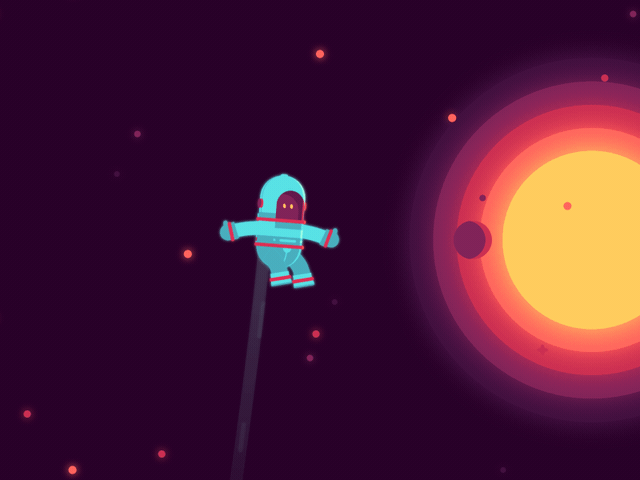

## 3.1 Sub Lesson

In [106]:
sublessons.size


63345

In [128]:
sublessons.head()

L1MC012  L1MC013  L1MC014  L1MC022  L1MC023  L1MC032  L1MC033  L1MC042  \
0    100.0     83.0      NaN     92.0     93.0      NaN      NaN      NaN   
1     70.0     78.0      NaN      NaN      NaN      NaN      NaN      NaN   
2     84.0      9.0      NaN    100.0      6.0     92.0     11.0    100.0   
3      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

   L1MC043  L1MC052   ...     L3PH153  L3PH154  L3PH162  L3PH163  L3PH164  \
0      NaN      NaN   ...         NaN      NaN      NaN      NaN      NaN   
1      NaN      NaN   ...         NaN      NaN      NaN      NaN      NaN   
2      9.0     81.0   ...         NaN      NaN      NaN      NaN      NaN   
3      NaN      NaN   ...         NaN      NaN      NaN      NaN      NaN   
4      NaN      NaN   ...         NaN      NaN      NaN      NaN      NaN   

   L3PH172  L3PH173  L3PH174  L3PH182  L3PH183  
0      NaN      NaN      NaN      NaN      NaN  
1      NaN      NaN      NaN      NaN      NaN  
2      NaN      NaN      NaN      NaN      NaN  
3      NaN      NaN      NaN      NaN      NaN  
4      NaN      NaN      NaN      NaN      NaN  

[5 rows x 309 columns]

In [365]:
desc = sublessons.describe().T
desc.head()

count       mean        std   min   25%   50%    75%    max
L1MC012  145.0  84.117241  20.435367  13.0  78.0  92.0  100.0  100.0
L1MC013  114.0  55.078947  33.726423   1.0  22.0  65.5   85.0  100.0
L1MC014    6.0  85.000000  17.606817  60.0  72.5  90.0  100.0  100.0
L1MC022   54.0  85.592593  17.392818  36.0  81.0  92.0  100.0  100.0
L1MC023   43.0  58.000000  36.147186   1.0  25.5  73.0   87.5  100.0

In [370]:
dropColumns = desc.columns[3:].values

/Applications/Anaconda/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  


ValueError: invalid literal for int() with base 10: '50%'

In [140]:
lessonSummary = desc.drop(dropColumns,axis=1)
lessonSummary.head()

count       mean        std
L1MC012  145.0  84.117241  20.435367
L1MC013  114.0  55.078947  33.726423
L1MC014    6.0  85.000000  17.606817
L1MC022   54.0  85.592593  17.392818
L1MC023   43.0  58.000000  36.147186

In [191]:
lessonSummary.reset_index(inplace=True) #把 index 转换成 column 以便作为参数处理

In [222]:

lessonSummary['roadmap']=lessonSummary['index'].apply(lambda s: s[:4])
lessonSummary['lesson']=lessonSummary['index'].apply(lambda s: int(s[4:6]))
lessonSummary['sublesson']=lessonSummary['index'].apply(lambda s: int(s[4:7]))
lessonSummary.sample(5)

index  level_0  count  mean        std roadmap  lesson  sublesson  \
304  L3PH172      304    3.0  57.0   3.605551    L3PH      17        172   
113  L2MC263      113    1.0  80.0        NaN    L2MC      26        263   
83   L2MC012       83   20.0  80.8  17.846126    L2MC       1         12   
295  L3PH142      295    5.0  64.0  14.195070    L3PH      14        142   
259  L3PH022      259    3.0  87.0  13.527749    L3PH       2         22   

         color  
304  18.849556  
113   6.283185  
83    6.283185  
295  18.849556  
259  18.849556

In [281]:
lessonSummary.sample(5)

index  level_0  count  mean        std roadmap  lesson  sublesson  \
92   L2MC053       92    2.0  73.5  23.334524    L2MC       5         53   
95   L2MC072       95    1.0  92.0        NaN    L2MC       7         72   
85   L2MC022       85    4.0  73.0  22.583180    L2MC       2         22   
293  L3PH133      293    2.0  87.5  12.020815    L3PH      13        133   
74   L1PH132       74    1.0  94.0        NaN    L1PH      13        132   

         color  
92   12.566371  
95   12.566371  
85   12.566371  
293  31.415927  
74    6.283185

In [ ]:
lessonSummary.set_index('index', drop=True, inplace=True) # 把 index 转回去

In [274]:
colorMap = { "L1MC" : "red",
            "L1PH" : "brown",
            "L2MC" : "green",
            "L2PH" : "blue",
            "L3MC" : "purple",
            "L3PH" : "black",
           }
roadmaps = ["L1MC","L1PH","L2MC","L2PH","L3MC","L3PH"]


In [275]:
lessonSummary['color']=lessonSummary['roadmap'].apply(lambda s: 2 * np.pi * roadmaps.index(s))
lessonSummary.sample(5)

index  level_0  count       mean        std roadmap  lesson  sublesson  \
120  L2MC313      120    1.0  69.000000        NaN    L2MC      31        313   
305  L3PH173      305    3.0  58.000000  50.477718    L3PH      17        173   
146  L2PH023      146    1.0  71.000000        NaN    L2PH       2         23   
63   L1PH064       63    3.0  93.333333   2.309401    L1PH       6         64   
218  L3MC103      218    1.0  50.000000        NaN    L3MC      10        103   

         color  
120  12.566371  
305  31.415927  
146  18.849556  
63    6.283185  
218  25.132741

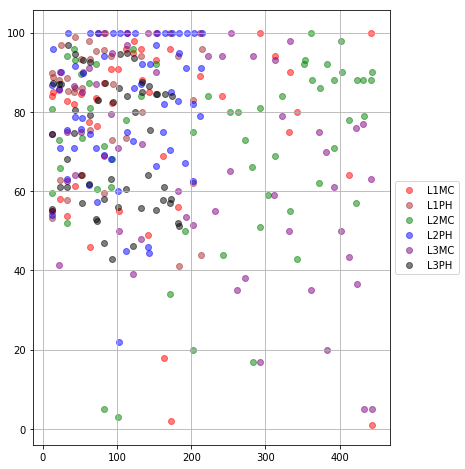

In [340]:

fig, ax = plt.subplots(figsize=(8,8))
for roadmap in roadmaps:
    roadmapGrades = lessonSummary[lessonSummary['roadmap']==roadmap]
#     ax.scatter(roadmapGrades['sublesson'],roadmapGrades['mean'],alpha=0.5,c=roadmapGrades['color'],cmap='hsv',label=roadmap)
    ax.scatter(roadmapGrades['sublesson'],roadmapGrades['mean'],alpha=0.5,color=colorMap[roadmap],label=roadmap)
# ax.legend()

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.grid(True)
# plt.figlegend()
plt.show()

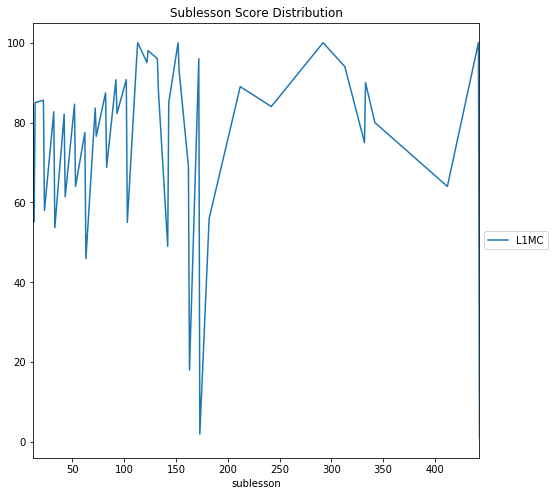

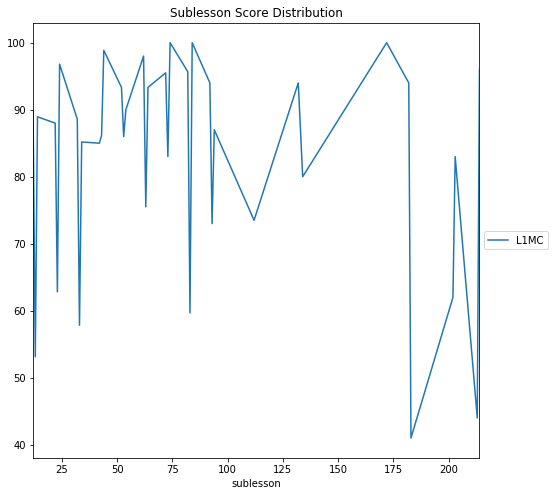

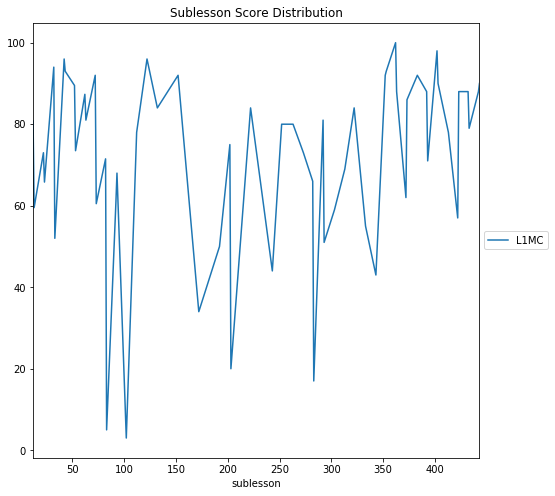

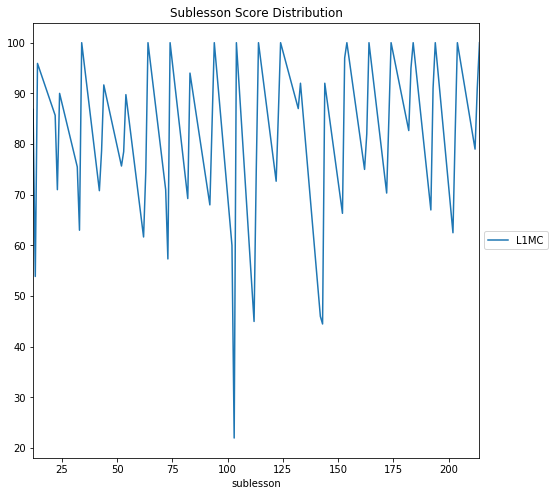

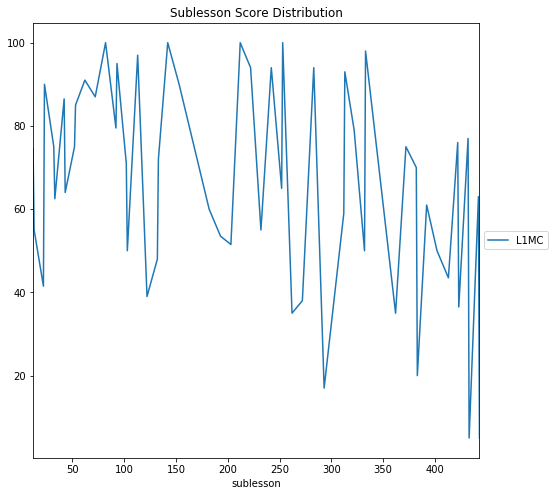

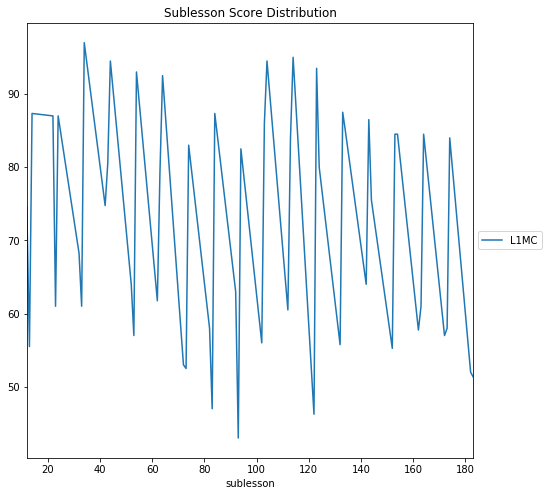

In [345]:
for roadmap in roadmaps:
    lessonSummary[lessonSummary['roadmap']==roadmap].plot(x='sublesson',y='mean',title="Sublesson Score Distribution",figsize=(8,8)).legend(roadmaps,loc='center left', bbox_to_anchor=(1, 0.5))



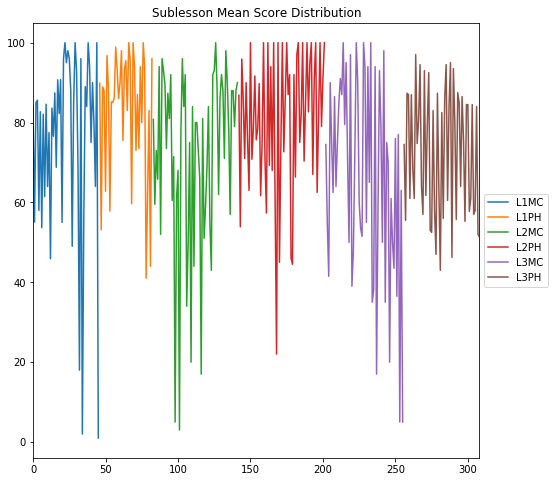

In [364]:
fig,ax = plt.subplots()
ax.grid(True)
for roadmap in roadmaps:
    lessonSummary[lessonSummary['roadmap']==roadmap]['mean'].plot(title="Sublesson Mean Score Distribution",figsize=(8,8)).legend(roadmaps,loc='center left', bbox_to_anchor=(1, 0.5))


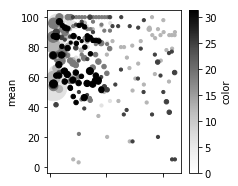

In [295]:
lessonSummary.plot.scatter(x='sublesson',y='mean',c='color',s=lessonSummary['count']*10)

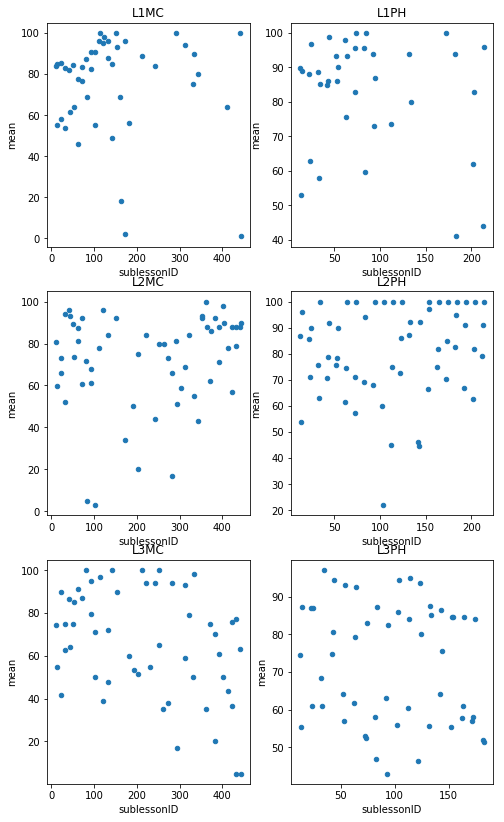

In [363]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 14))
for i,roadmap in enumerate(roadmaps):
    ax = axes[int(i/2)%3][i%2]
    lessonSummary[lessonSummary['roadmap']==roadmap].plot.scatter(ax=ax,x='sublesson',y='mean',title=roadmap)
    ax.set_xlabel('sublessonID')

## 3.2 section 

In [216]:
lessonProgress.sample()

bd  sections.L1MC0121  \
bid                                                                             
554d104d94ab496ea581240aa3beca6d  2010-06-19T00:00:00.000Z              100.0   

                                  sections.L1MC0122  sections.L1MC0123  \
bid                                                                      
554d104d94ab496ea581240aa3beca6d              100.0              100.0   

                                  sections.L1MC0124  sections.L1MC0125  \
bid                                                                      
554d104d94ab496ea581240aa3beca6d               13.0              100.0   

                                  sections.L1MC0126  sections.L1PH0121  \
bid                                                                      
554d104d94ab496ea581240aa3beca6d              100.0                NaN   

                                  sections.L1PH0122  sections.L1PH0123  ...   \
bid                                                                     ...    
554d104d94ab496ea581240aa3beca6d                NaN                NaN  ...    

                                  sublessons.L3MC122  sublessons.L3MC132  \
bid                                                                        
554d104d94ab496ea581240aa3beca6d                 NaN                 NaN   

                                  sublessons.L3MC212  sublessons.L1PH093  \
bid                                                                        
554d104d94ab496ea581240aa3beca6d                 NaN                 NaN   

                                  sublessons.L1PH094  sublessons.L2PH023  \
bid                                                                        
554d104d94ab496ea581240aa3beca6d                 NaN                 NaN   

                                  sublessons.L2PH083  sublessons.L3MC043  \
bid                                                                        
554d104d94ab496ea581240aa3beca6d                 NaN                 NaN   

                                  sublessons.L3MC153  year  
bid                                                         
554d104d94ab496ea581240aa3beca6d                 NaN  2010  

[1 rows x 2140 columns]

In [219]:
sectionSummary = sections.describe()
sectionSummary

L1MC0121    L1MC0122    L1MC0123    L1MC0124    L1MC0125   L1MC0126  \
count  142.000000  135.000000  134.000000  132.000000  132.000000  131.00000   
mean    85.464789   88.229630   79.507463   84.492424   88.333333   82.78626   
std     25.913019   24.960847   32.997550   31.249427   27.129226   29.84911   
min      5.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
25%     82.500000  100.000000   50.000000  100.000000  100.000000   67.00000   
50%    100.000000  100.000000  100.000000  100.000000  100.000000  100.00000   
75%    100.000000  100.000000  100.000000  100.000000  100.000000  100.00000   
max    100.000000  100.000000  100.000000  100.000000  100.000000  100.00000   

         L1PH0121    L1PH0122    L1PH0123    L1PH0124     ...       L3MC0327  \
count   81.000000   79.000000   77.000000   78.000000     ...            1.0   
mean    95.444444   94.025316   97.571429   97.397436     ...          100.0   
std     16.016398   21.541239   12.625609   13.414801     ...            NaN   
min     25.000000    0.000000   13.000000   14.000000     ...          100.0   
25%    100.000000  100.000000  100.000000  100.000000     ...          100.0   
50%    100.000000  100.000000  100.000000  100.000000     ...          100.0   
75%    100.000000  100.000000  100.000000  100.000000     ...          100.0   
max    100.000000  100.000000  100.000000  100.000000     ...          100.0   

       L3MC0431  L3MC0432  L3MC0433  L3MC0434  L3MC1531  L3MC1532  L3MC1533  \
count       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
mean        0.0     100.0      55.0     100.0      90.0      70.0     100.0   
std         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
min         0.0     100.0      55.0     100.0      90.0      70.0     100.0   
25%         0.0     100.0      55.0     100.0      90.0      70.0     100.0   
50%         0.0     100.0      55.0     100.0      90.0      70.0     100.0   
75%         0.0     100.0      55.0     100.0      90.0      70.0     100.0   
max         0.0     100.0      55.0     100.0      90.0      70.0     100.0   

       L3MC1534         year  
count       1.0   209.000000  
mean      100.0  2015.043062  
std         NaN     2.149030  
min       100.0  2008.000000  
25%       100.0  2013.000000  
50%       100.0  2016.000000  
75%       100.0  2017.000000  
max       100.0  2020.000000  

[8 rows x 1830 columns]

### 3.2.1 所有宝宝平均成绩

In [318]:
# babyScores = sectionSummary.loc['mean'].apply(pd.Series).T # 所有宝宝的平均得分
# babyScores = sections.loc['58179a05327647cb9725d6530d4e0786'].apply(pd.Series).T # 指定id宝宝的平均得分
babyScores = sections.groupby('age').mean() # 分龄宝宝的平均得分
babyScores

L1MC0121   L1MC0122   L1MC0123   L1MC0124   L1MC0125   L1MC0126  \
age                                                                           
Age [0,2)  85.802817  84.455882  74.808824  83.477612  86.584615  82.625000   
Age [2,5)  84.196078  95.744681  87.217391  89.422222  91.489362  80.340426   
Age [5+]   87.500000  83.400000  77.750000  76.800000  86.600000  89.050000   

             L1PH0121    L1PH0122    L1PH0123    L1PH0124    ...     L2PH1326  \
age                                                          ...                
Age [0,2)   95.883721   96.750000   96.575000   97.850000    ...          NaN   
Age [2,5)   92.888889   87.785714   98.076923   95.666667    ...        100.0   
Age [5+]   100.000000  100.000000  100.000000  100.000000    ...          NaN   

           L3MC0327  L3MC0431  L3MC0432  L3MC0433  L3MC0434  L3MC1531  \
age                                                                     
Age [0,2)       NaN       NaN       NaN       NaN       NaN       NaN   
Age [2,5)     100.0       0.0     100.0      55.0     100.0      90.0   
Age [5+]        NaN       NaN       NaN       NaN       NaN       NaN   

           L3MC1532  L3MC1533  L3MC1534  
age                                      
Age [0,2)       NaN       NaN       NaN  
Age [2,5)      70.0     100.0     100.0  
Age [5+]        NaN       NaN       NaN  

[3 rows x 1829 columns]

In [319]:
listenIds = list(set(babyScores.columns).intersection(set(catIDsMap['listen'].values)))
readIDs = list(set(babyScores.columns).intersection(set(catIDsMap['read'].values)))
speakIDs = list(set(babyScores.columns).intersection(set(catIDsMap['speak'].values)))
writeIDs = list(set(babyScores.columns).intersection(set(catIDsMap['write'].values)))



In [320]:
listenScore = babyScores[listenIds].mean(axis=1)
readScore = babyScores[readIDs].mean(axis=1)
speakScore = babyScores[speakIDs].mean(axis=1)
writeScore = babyScores[writeIDs].mean(axis=1)
scores = [readScore,writeScore,speakScore,listenScore]
print(scores)
print(catIDsMap.keys())

[age
Age [0,2)    65.800687
Age [2,5)    65.746380
Age [5+]     81.307071
dtype: float64, age
Age [0,2)    93.627343
Age [2,5)    86.921775
Age [5+]     96.848485
dtype: float64, age
Age [0,2)    70.034822
Age [2,5)    63.342151
Age [5+]     65.239379
dtype: float64, age
Age [0,2)    73.243739
Age [2,5)    76.613091
Age [5+]     82.462210
dtype: float64]
['read', 'write', 'speak', 'listen']


In [321]:
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    def draw_poly_patch(self):
        # rotate theta such that the first axis is at the top
        verts = unit_poly_verts(theta + np.pi / 2)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def __init__(self, *args, **kwargs):
            super(RadarAxes, self).__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta + np.pi / 2)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts





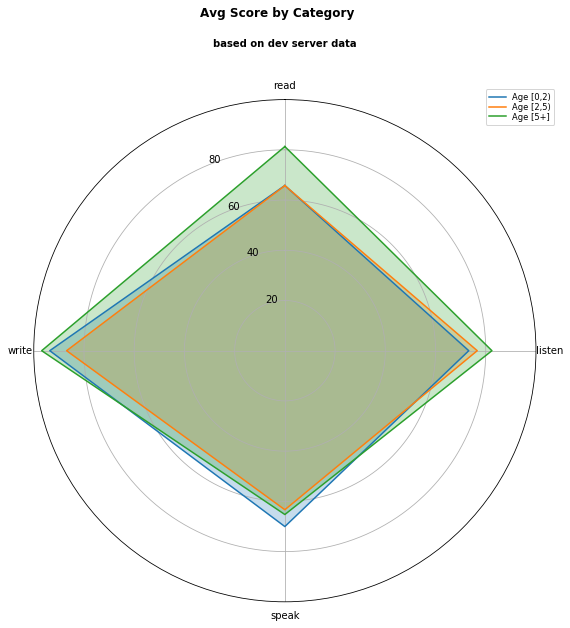

In [322]:

N = 4
theta = radar_factory(N)

catLabels = catIDsMap.keys()
d=scores

fig, ax = plt.subplots(figsize=(9, 9), 
                         subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)


# Plot the four cases from the example data on separate axes
ax.set_rgrids([20, 40, 60, 80])
ax.set_title("based on dev server data", weight='bold', size='medium', position=(0.5, 1.1),
             horizontalalignment='center', verticalalignment='center')
ax.set_ylim(ymin=0,ymax=100)
ax.plot(theta, d)
ax.fill(theta, d, alpha=0.25)
ax.set_varlabels(catLabels)

groups = listenScore.index
legend = ax.legend(groups, loc=(0.9, .95),
                   labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, 'Avg Score by Category',
         horizontalalignment='center', color='black', weight='bold',
         size='large')

plt.show()

In [267]:
listenScore.index

Int64Index([2008, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2020], dtype='int64', name=u'year')